In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# Importing Libraries 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

# Creating Data Transform Object

- Resizing Image
- Applying random Horizontal flip
- Converting image to Tensor
- Normalizing data

In [ ]:
mean = np.array([0.5, 0.5, 0.5])
std = np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

# Preprocessing Data

- Importing dataset
- Applying transformation on data using data_transform object

In [ ]:
data_dir = '/content/gdrive/MyDrive/flower_dataset'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=0)
              for x in ['train', "val"]}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', "val"]}
class_names = image_datasets['train'].classes

print(len(class_names), (dataset_sizes["train"]))

102 1020


# Selecting Device

- Device will be set as GPU if GPU is present.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
def imshow(inp, title):

    """Imshow for Tensor"""
    
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

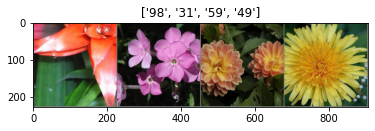

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#DIsplaying images
imshow(out, title=[class_names[x] for x in classes])

In [ ]:
# Creating variables to plot accuracy diagram
list_loss, list_acc, list_val_acc, list_val_loss = [], [], [], []

# Model Training Loop

In [ ]:
def train_model(model, criterion, optimizer, scheduler, dlr = False,num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # calculating loss and prediction accuracy of each input and adding it
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if dlr:
              if phase == 'train':
                  scheduler.step()

            # Calculation Loss and accuracy for the epoch
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Storing model Accuracy and loss for plotting diagram
            if phase == "train":
              list_acc2.append(epoch_acc)
              list_loss2.append(epoch_loss)
            else:
              list_val_acc2.append(epoch_acc)
              list_val_loss2.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Printing time elapsed during training
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    # Printing best Accuracy achieved during training
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model



# Creating model

- Importing pretrained model
- Freezing pretained weights 
- Creating Custom layer
- Setting hyperparameters

In [ ]:
# Load a pretrained model and reset final fully connected layer.
model = models.resnet18(pretrained=True)

# Freezing pretrained weights and parameters
for param in model.parameters():
    param.requires_grad = False

# Getting model features
num_ftrs = model.fc.in_features

# Creating custom linear dense layer for output
# Here the size of each output sample is set to 102.
model.fc = nn.Linear(num_ftrs,  len(class_names))

# Passing model to the device
model = model.to(device)

# Cross Entropy as loss function
criterion = nn.CrossEntropyLoss()

# Adam opmtimzer is selected with learning rate as 0.001
optimizer = optim.Adam(model.parameters(), lr=0.001)

# StepLR Decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.005 every 10 epochs
# Learning rate scheduling should be applied after optimizer’s update
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.005)

# Training model

- If dlr is true, weight decay is activated, by default set to False

In [ ]:
model = train_model(model, criterion, optimizer, step_lr_scheduler, dlr = True,num_epochs=100)

Epoch 0/99
----------
train Loss: 3.4775 Acc: 0.2039
val Loss: 2.1681 Acc: 0.5029

Epoch 1/99
----------
train Loss: 2.7517 Acc: 0.3696
val Loss: 1.7589 Acc: 0.5941

Epoch 2/99
----------
train Loss: 2.3483 Acc: 0.4520
val Loss: 1.5378 Acc: 0.6157

Epoch 3/99
----------
train Loss: 2.0394 Acc: 0.5216
val Loss: 1.1959 Acc: 0.6951

Epoch 4/99
----------
train Loss: 1.7139 Acc: 0.6059
val Loss: 1.0180 Acc: 0.7461

Epoch 5/99
----------
train Loss: 1.6014 Acc: 0.6118
val Loss: 0.9584 Acc: 0.7608

Epoch 6/99
----------
train Loss: 1.4111 Acc: 0.6873
val Loss: 0.9391 Acc: 0.7431

Epoch 7/99
----------
train Loss: 1.3864 Acc: 0.6657
val Loss: 0.8498 Acc: 0.7637

Epoch 8/99
----------
train Loss: 1.2987 Acc: 0.6843
val Loss: 0.8062 Acc: 0.7667

Epoch 9/99
----------
train Loss: 1.1652 Acc: 0.7284
val Loss: 0.8027 Acc: 0.7755

Epoch 10/99
----------
train Loss: 1.1259 Acc: 0.7324
val Loss: 0.7502 Acc: 0.7971

Epoch 11/99
----------
train Loss: 1.1189 Acc: 0.7451
val Loss: 0.7341 Acc: 0.7863

Ep

# Saving Model 

In [ ]:
torch.save(model_basic.state_dict(), "/content/sample_data/model_dlr")

# Plotting accuracy diagram

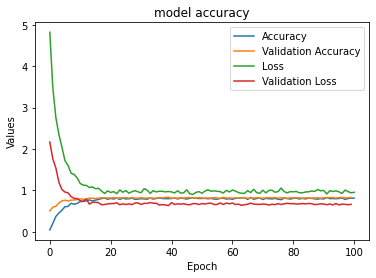

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list_acc)
plt.plot(list_val_acc)
plt.plot(list_loss)
plt.plot(list_val_loss)
plt.title('model accuracy')
plt.ylabel('Values')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation Accuracy', "Loss", "Validation Loss"], loc='upper right')
plt.show()